<a href="https://colab.research.google.com/github/Helena26-ai/Rainforcement_project/blob/Helena/Pong_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install gymnasium[atari] ale-py stable-baselines3 tensorboard matplotlib -q

In [12]:
import os
#import ale_py
import gymnasium as gym
from gymnasium import spaces
import collections
import typing as tt
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard.writer import SummaryWriter
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt
from stable_baselines3.common.atari_wrappers import AtariWrapper
from dataclasses import dataclass

In [13]:
os.makedirs("my_runs", exist_ok=True)
os.makedirs("my_runs/video", exist_ok=True)

In [14]:
# DQN
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        conv_out_size = self.conv(torch.zeros(1, *input_shape)).shape[1]
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        return self.fc(self.conv(x.float() / 255))

In [15]:
class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs = self.observation_space
        self.observation_space = spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=(obs.shape[2], obs.shape[0], obs.shape[1]), dtype=obs.dtype)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps):
        super().__init__(env)
        self.buffer = collections.deque(maxlen=n_steps)
        obs = env.observation_space
        self.observation_space = spaces.Box(
            low=np.repeat(obs.low, n_steps, axis=0),
            high=np.repeat(obs.high, n_steps, axis=0),
            dtype=obs.dtype)

    def reset(self, **kwargs):
        for _ in range(self.buffer.maxlen - 1):
            self.buffer.append(self.env.observation_space.low)
        obs, info = self.env.reset(**kwargs)
        return self.observation(obs), info

    def observation(self, observation):
        self.buffer.append(observation)
        return np.concatenate(self.buffer)

def make_env(env_name: str, **kwargs):
    env = gym.make(env_name, **kwargs)
    env = AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=4)
    return env

In [16]:
DEFAULT_ENV_NAME = "PongNoFrameskip-v4"
MEAN_REWARD_BOUND = 19
GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000
EPSILON_DECAY_LAST_FRAME = 150000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01

@dataclass
class Experience:
    state: np.ndarray
    action: int
    reward: float
    done_trunc: bool
    new_state: np.ndarray

class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience: Experience):
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> list:
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[idx] for idx in indices]

class Agent:
    def __init__(self, env: gym.Env, exp_buffer: ExperienceBuffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self.state = None
        self.total_reward = 0.0
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: DQN, device: torch.device, epsilon=0.0):
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state_v = torch.tensor(np.array([self.state]), device=device)
            q_vals = net(state_v)
            action = torch.argmax(q_vals).item()

        new_state, reward, done, trunc, _ = self.env.step(action)
        self.total_reward += reward
        self.exp_buffer.append(Experience(self.state, action, reward, done or trunc, new_state))
        self.state = new_state

        if done or trunc:
            r = self.total_reward
            self._reset()
            return r
        return None

def batch_to_tensors(batch, device):
    states = torch.tensor(np.array([e.state for e in batch]), device=device)
    actions = torch.tensor([e.action for e in batch], dtype=torch.long, device=device)
    rewards = torch.tensor([e.reward for e in batch], dtype=torch.float32, device=device)
    dones = torch.tensor([e.done_trunc for e in batch], dtype=torch.bool, device=device)
    next_states = torch.tensor(np.array([e.new_state for e in batch]), device=device)
    return states, actions, rewards, dones, next_states

def calc_loss(batch, net, tgt_net, device):
    states, actions, rewards, dones, next_states = batch_to_tensors(batch, device)
    state_action_values = net(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
    with torch.no_grad():
        next_state_values = tgt_net(next_states).max(1)[0]
        next_state_values[dones] = 0.0
    expected_values = rewards + GAMMA * next_state_values
    return nn.MSELoss()(state_action_values, expected_values)

# Start training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = make_env(DEFAULT_ENV_NAME)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
writer = SummaryWriter(log_dir="my_runs")

epsilon = EPSILON_START
frame_idx = 0
best_mean_reward = None
rewards = []
ts = time.time()
ts_frame = 0

while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)
    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(rewards[-100:])
        print(f"{frame_idx}: games {len(rewards)}, reward {m_reward:.3f}, eps {epsilon:.2f}, speed {speed:.2f} f/s")
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)
        if best_mean_reward is None or best_mean_reward < m_reward:
            torch.save(net.state_dict(), f"my_runs/best_{m_reward:.0f}.dat")
            best_mean_reward = m_reward
        if m_reward > MEAN_REWARD_BOUND:
            print("Solved!")
            break

    if len(buffer) < REPLAY_START_SIZE:
        continue

    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    batch = buffer.sample(BATCH_SIZE)
    optimizer.zero_grad()
    loss = calc_loss(batch, net, tgt_net, device)
    loss.backward()
    optimizer.step()

writer.close()

977: games 1, reward -20.000, eps 0.99, speed 892.82 f/s
1859: games 2, reward -20.500, eps 0.99, speed 887.37 f/s
2621: games 3, reward -20.667, eps 0.98, speed 910.89 f/s
3637: games 4, reward -20.500, eps 0.98, speed 898.30 f/s
4538: games 5, reward -20.400, eps 0.97, speed 922.94 f/s
5574: games 6, reward -20.000, eps 0.96, speed 892.70 f/s
6425: games 7, reward -20.143, eps 0.96, speed 930.86 f/s
7488: games 8, reward -20.000, eps 0.95, speed 909.34 f/s
8370: games 9, reward -20.111, eps 0.94, speed 905.44 f/s
9252: games 10, reward -20.200, eps 0.94, speed 863.47 f/s
10074: games 11, reward -20.273, eps 0.93, speed 633.08 f/s
11280: games 12, reward -20.167, eps 0.92, speed 174.31 f/s
12359: games 13, reward -20.077, eps 0.92, speed 174.62 f/s
13168: games 14, reward -20.143, eps 0.91, speed 178.68 f/s
14050: games 15, reward -20.200, eps 0.91, speed 180.68 f/s
14812: games 16, reward -20.250, eps 0.90, speed 175.67 f/s
15688: games 17, reward -20.235, eps 0.90, speed 172.94 f/s


In [17]:
from gymnasium.wrappers import RecordVideo
import glob
from IPython.display import Video, display

ENV_NAME = "PongNoFrameskip-v4"
VIDEO_PATH = "my_runs/video"
MODEL_PATH = sorted(glob.glob("my_runs/*.dat"))[-1]  # ostatni najlepszy model

env = make_env(ENV_NAME, render_mode="rgb_array")
env = RecordVideo(env, video_folder=VIDEO_PATH, episode_trigger=lambda x: True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = DQN(env.observation_space.shape, env.action_space.n).to(device)
net.load_state_dict(torch.load(MODEL_PATH, map_location=device))

state, _ = env.reset()
total_reward = 0.0

while True:
    state_v = torch.tensor(np.expand_dims(state, 0)).to(device)
    q_vals = net(state_v)
    action = torch.argmax(q_vals).item()
    state, reward, done, trunc, _ = env.step(action)
    total_reward += reward
    if done or trunc:
        break

env.close()
print(f"Total reward: {total_reward}")

video_file = glob.glob(f"{VIDEO_PATH}/*.mp4")[0]
display(Video(video_file, embed=True))

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/my_runs/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Total reward: 18.0


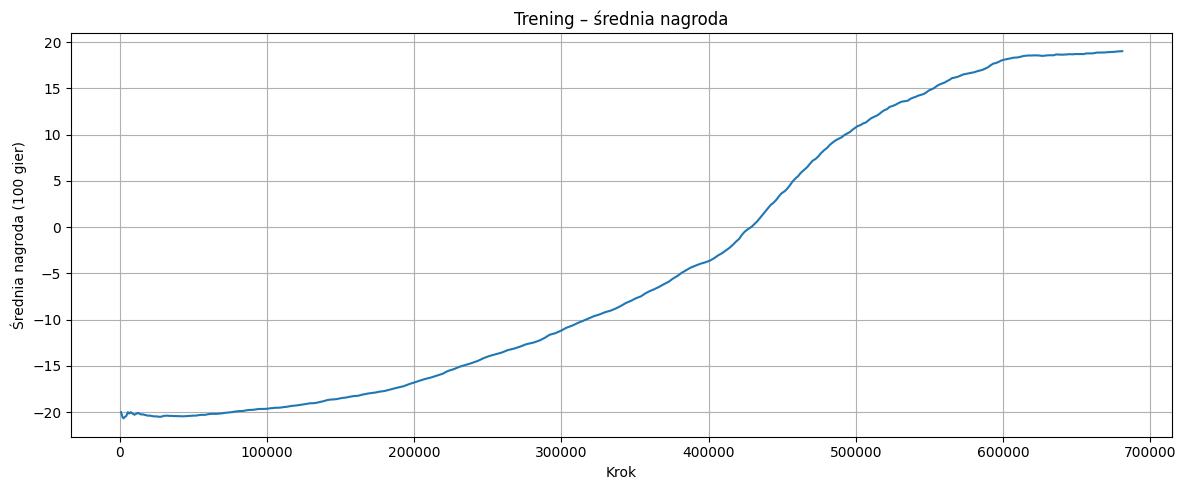

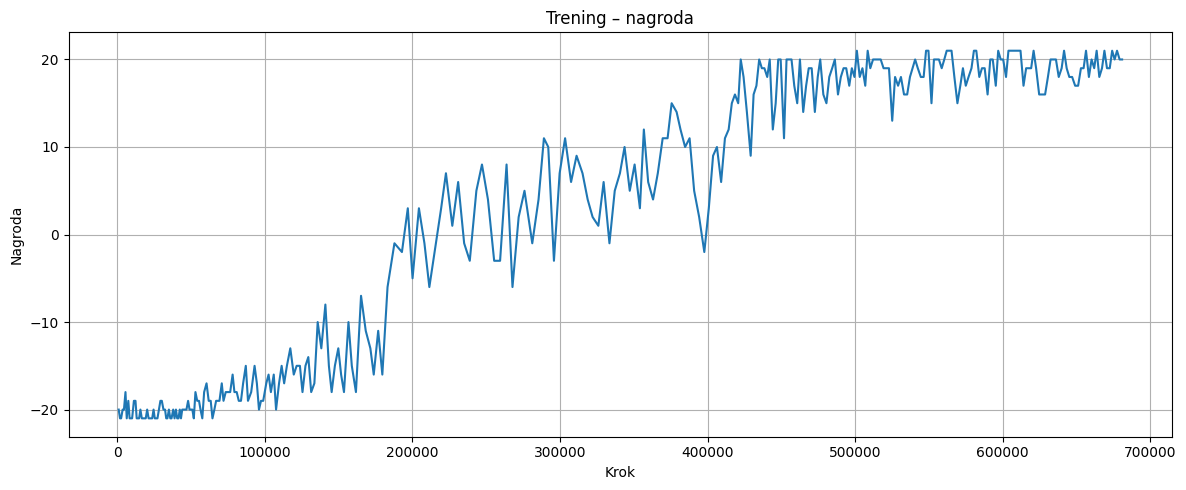

In [20]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# === Wykres nagród z TensorBoard (trening) ===
event_files = []
for root, dirs, files in os.walk("my_runs"):
    for file in files:
        if file.startswith("events.out.tfevents"):
            event_files.append(os.path.join(root, file))

assert len(event_files) > 0, "Brak logów treningu (TensorBoard)."

ea = event_accumulator.EventAccumulator(event_files[0])
ea.Reload()

rewards = ea.Scalars("reward_100")
steps = [s.step for s in rewards]
reward_values = [s.value for s in rewards]

plt.figure(figsize=(12, 5))
plt.plot(steps, reward_values)
plt.xlabel("Krok")
plt.ylabel("Średnia nagroda (100 gier)")
plt.title("Trening – średnia nagroda")
plt.grid()

plt.tight_layout()
plt.savefig("my_runs/dqn_rewards_100.png")
plt.show()

rewards = ea.Scalars("reward")
steps = [s.step for s in rewards]
reward_values = [s.value for s in rewards]

plt.figure(figsize=(12, 5))
plt.plot(steps, reward_values)
plt.xlabel("Krok")
plt.ylabel("Nagroda")
plt.title("Trening – nagroda")
plt.grid()

plt.tight_layout()
plt.savefig("my_runs/dqn_rewards.png")
plt.show()